In [1]:
from cosmikyu import gan, config, datasets, transforms, stats, mpi, utils
from cosmikyu import nn as cnn
import numpy as np
import os
import torchvision.transforms as pytransforms
import matplotlib.pyplot as plt
import torch as tf
import mlflow
from orphics import maps
from pixell import enplot, enmap

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
cuda = True
compt_idxes = [0,1,2,3,4]
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
shape = (len(compt_idxes),128,128)
latent_dim = 256
sample_interval = 200
batch_size = 1
nepochs=50

_, wcs = maps.rect_geometry(width_arcmin=64*5., height_arcmin=64, px_res_arcmin=0.5)

# Configure data loader
os.makedirs(data_dir, exist_ok=True)
os.makedirs(sehgal_dir, exist_ok=True)

#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/141020_normalization_info_validation.npz"
#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/191020_logminmax_normalization_info_validation.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
#SDN = transforms.SehgalDataNormalizerScaledLogZ(norm_info_file)
#SDUN = transforms.SehgalDataUnnormalizerScaledLogZ(norm_info_file)
#SDN = transforms.SehgalDataNormalizerScaledLogMinMax(norm_info_file)
#SUN = transforms.SehgalDataUnnormalizerScaledLogMinMax(norm_info_file)
RF = transforms.RandomFlips(p_v=0.5, p_h=0.5)
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test141020", transforms=[SDN], dummy_label=False)

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
STanh = cnn.ScaledTanh(30., 2./30.)
LF = cnn.LinearFeature(5,5)
MCM = transforms.MultiComptMultiply([1, 0.9991, 0.9834, 0.9894, 1.0034]   )
#STanh = cnn.ScaledTanh(1., 1.)
DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", shape, latent_dim, cuda=False, nconv_fcgen=64,
                                  nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, 
                          kernal_size=4, stride=2, padding=1, output_padding=0, gen_act=[LF,STanh])



#experiment_id = "ba37629bac2c42e090dceef57ff60660"
experiment_id = "63101414f2434a3e93cd28663a89f879"
#model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_151020/{}/model".format(experiment_id)
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_211020/{}/model".format(experiment_id)
nsample = 1000
nbins = 10000
data = np.zeros((5, 128, 128*nsample))
#DCGAN_WGP.load_states(model_dir)
print(model_dir)
save_points = np.arange(0,1,1)
generated = {}
for save_point in save_points:
    print("processing save points {}".format(save_point))
    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))

    for i in range(nsample):
        if i % 1000 == 0: print(i)
        sidx = 128*i
        data[...,sidx: sidx+128] = DCGAN_WGP.generate_samples(1).data.numpy()[0]
    data = MCM(data)
    print(np.max(data))
    MB = stats.FastMultBinner((-30,30), nbins, shape[0])
    MB.bin(data)

    temp = MB.get_info()
    
    for key in range(5):
        generated[SDN.channel_idxes[key]+"_{}".format(save_point)] = temp[key].copy()
print("Done")
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_normalized_histogram_generated_{}.npz".format(nbins), **generated)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.M

[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_211020/63101414f2434a3e93cd28663a89f879/model
processing save points 0
loading saved states _0
0
29.57729763374329
Done


In [6]:
for save_point in save_points:
    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    print(DCGAN_WGP.generator.model[-2].weight)
    print(DCGAN_WGP.generator.model[-2].bias)

loading saved states _0
Parameter containing:
tensor([0.8556, 0.8901, 0.8084, 0.8205, 2.5591], requires_grad=True)
Parameter containing:
tensor([-0.0486,  0.0113,  0.0296, -0.0023, -0.0751], requires_grad=True)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


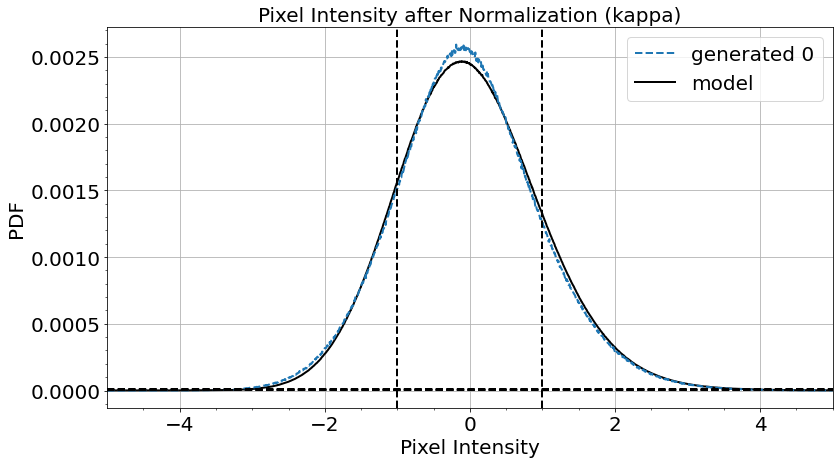

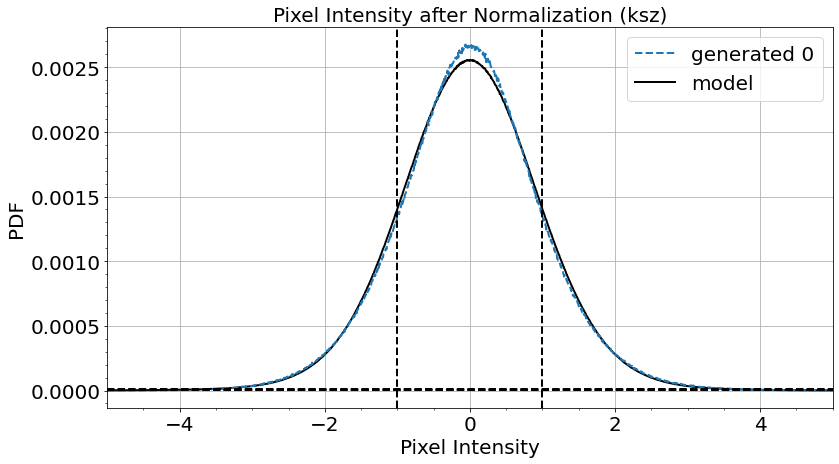

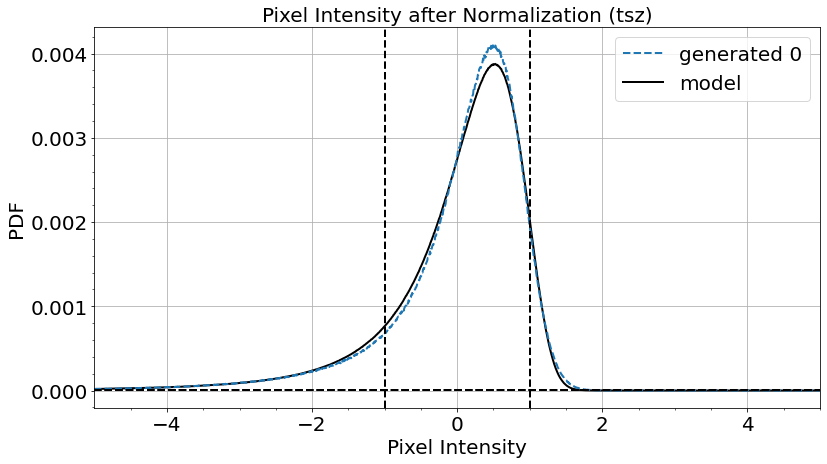

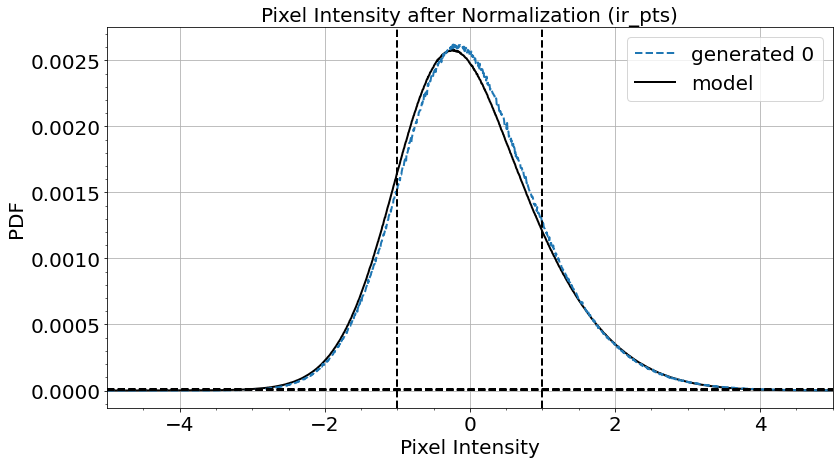

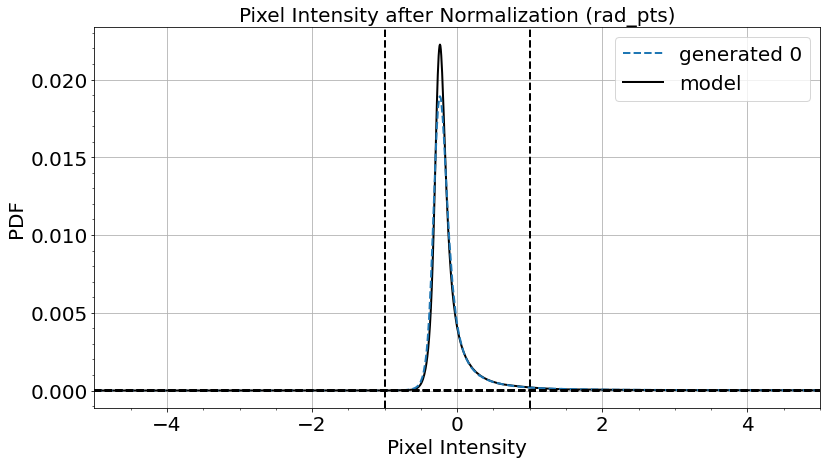

In [8]:
model =  utils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_normalized_histogram_test_{}.npz".format(nbins))
generated = utils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_normalized_histogram_generated_{}.npz".format(nbins))

compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
for key in compts:
    fig = plt.figure(figsize=(13, 7))
    ax = fig.gca()
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    plt.plot(bins_model, pdf_model, alpha=1, ls="-", lw=2, color="k")
    
    for save_point in save_points[:]:
        gen_key = "{}_{}".format(key, save_point)
        hist_generated = generated[gen_key]['hist']
        bins_generated = generated[gen_key]["bin_centers"]
        nsum_generated = np.sum(hist_generated)
        pdf_hist = hist_generated/nsum_generated   
        plt.plot(bins_generated, pdf_hist, alpha=1, lw=2, ls="--", label="generated {}".format(save_point))
    
    plt.plot([], [], label="model", ls="-", lw=2, color="k")
    #plt.plot([], [], label="generated", ls="-", lw=2, color="b")

    plt.title("Pixel Intensity after Normalization (%s)"%key, fontsize=20)
    plt.xlabel("Pixel Intensity", fontsize=20)
    plt.ylabel("PDF", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    plt.axvline(x=1, ls="--", lw=2, color="k")
    plt.axvline(x=-1, ls="--", lw=2, color="k")
    plt.axhline(y=1e-5, ls="--", lw=2, color="k")
    plt.axhline(y=1e-6, ls="--", lw=2, color="k")
    plt.axhline(y=1e-7, ls="--", lw=2, color="k")
    plt.xlim(-5,5)
    plt.yscale("linear")
    plt.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=True)
    plt.grid()
    plt.show()
    


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


KeyError: 'kappa_2'

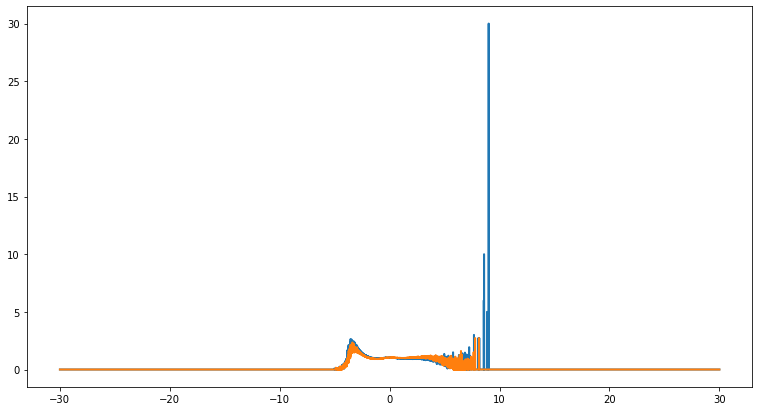

In [26]:
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
for key in compts:
    fig = plt.figure(figsize=(13, 7))
    ax = fig.gca()
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    
    for save_point in save_points:
        gen_key = "{}_{}".format(key, save_point)
        hist_generated = generated[gen_key]['hist']
        bins_generated = generated[gen_key]["bin_centers"]
        nsum_generated = np.sum(hist_generated)
        pdf_hist = hist_generated/nsum_generated   
        plt.plot(bins_generated, np.nan_to_num(pdf_hist/pdf_model), alpha=1, lw=2, ls="-", label="sp {}".format(save_point))


    plt.title("Pixel Intensity after Normalization (%s)"%key, fontsize=20)
    plt.xlabel("Pixel Intensity", fontsize=20)
    plt.ylabel("PDF", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    plt.axvline(x=1, ls="--", lw=2, color="k")
    plt.axvline(x=-1, ls="--", lw=2, color="k")
    plt.xlim(-30,30)
    plt.ylim(0,2)
    plt.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=True)
    plt.grid()
    plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['rad_pts', 'ir_pts', 'tsz', 'ksz', 'kappa']
Original Sehgal sim (64x64) arcmin^2


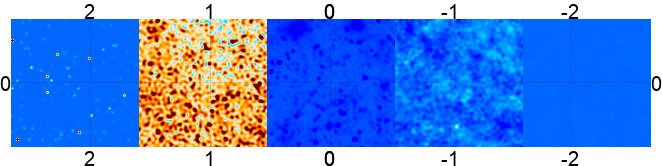

ML Reproduction (64x64) arcmin^2


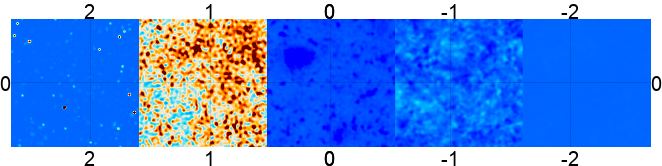

In [7]:
def make_hstrip(array):
    shape = array.shape
    if shape[0] < 2: return array
    else:
        nc, ny, nx = shape
        nnx = nx*nc
        ret = np.zeros((ny, nnx))
        for i in range(nc):
            sx = i*nx
            ret[:,sx:sx+nx] = array[i,...].copy()
        return ret
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
print(SDN.channel_idxes[::-1])
print("Original Sehgal sim (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(SDS_test[3])), wcs))
print("ML Reproduction (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(DCGAN_WGP.generate_samples(1).data.numpy()[0])), wcs))

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 kappa
1 ksz
2 tsz
3 ir_pts
4 rad_pts


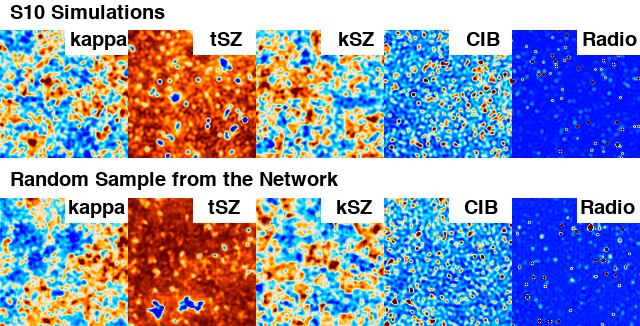

/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/plots/141020_stamp_stacked.png


In [8]:
from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 


plot_dir = os.path.join(config.default_output_dir, "plots")
def plot_path(x):
    return os.path.join(plot_dir, x)

_, wcs = maps.rect_geometry(width_arcmin=64., height_arcmin=64, px_res_arcmin=0.5)
emap_test = enmap.enmap(SDUN(SDS_test[10]), wcs)
emap_gen = enmap.enmap(SDUN(DCGAN_WGP.generate_samples(1).data.numpy()[0]), wcs)
for i, idx in enumerate(SDN.channel_idxes):
    print(i,idx)
    plot_test = enplot.plot(emap_test[i], grid=False)
    plot_gen = enplot.plot(emap_gen[i], grid=False)
    
    enplot.write(plot_path("{}_test".format(idx)), plot_test)
    enplot.write(plot_path("{}_gen".format(idx)), plot_gen)
    
nimages = len(SDN.channel_idxes)
imgs_test = [None]*nimages
imgs_gen = [None]*nimages

titles = {"kappa": "kappa", "ksz": "  kSZ", "tsz": "  tSZ", "ir_pts": "  CIB", "rad_pts": "Radio"}

swap = [0,2,1,3,4]

for i, idx in enumerate([SDN.channel_idxes[i] for i in swap]):
    fontsize = 20 if idx == "kappa" else 20
    font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica-Bold.ttf", fontsize)
    imgs_test[i] = Image.open(plot_path("{}_test.png".format(idx)))
    draw = ImageDraw.Draw(imgs_test[i])
    
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((70, 0), titles[idx], fill="black",font=font)
    
    imgs_gen[i] = Image.open(plot_path("{}_gen.png".format(idx)))
    draw = ImageDraw.Draw(imgs_gen[i])
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((68, 0), titles[idx], fill="black",font=font)
    #display(imgs_gen[i])

def get_concat_h(im1, im2, wspace=0):
    dst = Image.new('RGB', (im1.width+wspace + im2.width, im1.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+wspace, 0))
    return dst

def get_concat_v(im1, im2, hspace=40):
    dst = Image.new('RGB', (im1.width, im1.height+hspace+im2.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height+hspace))
    return dst

def pad(im, tpad=30, bpad=0, lpad=0, rpad=0):
    dst = Image.new('RGB', (im.width+lpad+rpad, im.height+tpad+bpad), color="#FFFFFF")
    dst.paste(im, (lpad, tpad))
    return dst

strip_test = imgs_test[0].copy()
strip_gen = imgs_gen[0].copy()
for i in range(1,nimages):
    strip_test = get_concat_h(strip_test, imgs_test[i])
    strip_gen = get_concat_h(strip_gen, imgs_gen[i])
padded = pad(get_concat_v(strip_test, strip_gen))
draw = ImageDraw.Draw(padded)
draw.text((10, 3), "S10 Simulations", fill="black",font=font)
draw.text((10, 170), "Random Sample from the Network", fill="black",font=font)
display(padded)

print(plot_path("141020_stamp_stacked.png"))
padded.save(plot_path("141020_stamp_stacked.png"), "png")